In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
#定義類別與其整數對應

class_mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}

In [3]:
#讀取每張圖片，與其標籤
# OpenCV 本身就有提供讀取圖片檔的函數可用，讀取一般的圖片檔，只要呼叫 cv2.imread 即可將圖片讀取進來
# 以 cv2.imread 讀進來的資料，會儲存成一個 NumPy 的陣列

#  在OpenCV中，图像不是用常规的RGB颜色通道来存储的，它们用的是BGR顺序。当读取一幅图像后，
#  默认的是BGR，不过有很多转换方式是可以利用的。颜色空间转换可以用函数cvtColor()函数

# # 使用 OpenCV 讀取圖檔
# img_bgr = cv2.imread('image.jpg')

# # 將 BGR 圖片轉為 RGB 圖片
# img_rgb = img_bgr[:,:,::-1]

# # 或是這樣亦可
# # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# # 使用 Matplotlib 顯示圖片
# plt.imshow(img_rgb)
# plt.show()


img_paths = glob.glob('/home/jovyan/Midterm_DL/train/*/*.jpg')
images, labels = [], []
img_sizes = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)
    label = img_path.split('/')[-2]
    label = class_mapping.get(label)
    images.append(img)
    labels.append(label)
images = np.array(images)
labels = np.uint8(labels)

In [4]:
images.shape

(588, 224, 224, 3)

In [5]:
x_Train4D = images.reshape(images.shape[0],224,224,3).astype('float32') 
x_Train4D.shape

(588, 224, 224, 3)

In [6]:
x_Train4D_normalize = x_Train4D/255

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train_1, y_valid_1 = train_test_split(x_Train4D_normalize, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    )

In [8]:
y_train = np_utils.to_categorical(y_train_1)
y_valid = np_utils.to_categorical(y_valid_1)

In [9]:
X_train.shape

(470, 224, 224, 3)

In [10]:
y_train.shape

(470, 10)

In [11]:
X_valid.shape

(118, 224, 224, 3)

In [12]:
y_valid.shape

(118, 10)

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
# 此例完全不鎖層，充分的 fine tuning
model_name = 'VGG16-Fine-Tune'
num_classes = 10
img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,
                                            input_shape=(img_rows, img_cols, img_channel))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

epochs = 100
batch_size = 10

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    steps_per_epoch=100,
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 2.4785 - accuracy: 0.1212
Epoch 00001: val_loss improved from inf to 2.18404, saving model to ./saved_models/VGG16-Fine-Tune.h5
100/100 [==============================] - 18s 177ms/step - loss: 2.4794 - accuracy: 0.1210 - val_loss: 2.1840 - val_accuracy: 0.1864
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 2.2167 - accuracy: 0.2182
Epoch 00002: val_loss improved from 2.18404 to 1.92590, saving model to ./saved_models/VGG16-Fine-Tune.h5
100/100 [==============================] - 15s 153ms/step - loss: 2.2151 - accuracy: 0.2180 - val_loss: 1.9259 - val_accuracy: 0.3559
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 1.8779 - accuracy: 0.3414
Epoch 00003: val_loss improved from 1.92590 to 1.43269, saving model to ./saved_models/VGG16-Fine-Tune.h5
100/100 [==============================] - 15s 152ms/step - loss: 1.8786 - accuracy: 0.3420 - val_loss: 1.4327 - val_accuracy: 

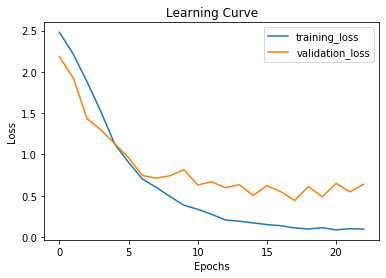

In [16]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

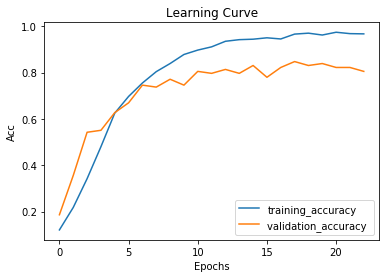

In [17]:
training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# Vilidation Set 預測錯誤分析

In [18]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

118/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
X_valid_prediction = model.predict(X_valid)
prediction_X_valid = X_valid_prediction.argmax(axis=-1)

In [20]:
prediction_X_valid

array([2, 5, 8, 0, 6, 5, 9, 0, 0, 2, 3, 7, 2, 2, 6, 7, 1, 6, 1, 6, 8, 2,
       1, 8, 9, 9, 5, 7, 5, 6, 3, 2, 5, 0, 7, 4, 9, 1, 5, 5, 7, 6, 9, 2,
       2, 6, 3, 6, 1, 6, 0, 3, 6, 9, 7, 3, 7, 1, 6, 4, 2, 4, 6, 9, 9, 7,
       1, 8, 2, 9, 0, 1, 0, 1, 1, 8, 1, 7, 9, 1, 1, 3, 6, 1, 6, 5, 4, 6,
       1, 2, 7, 1, 0, 5, 0, 5, 6, 3, 6, 0, 4, 4, 5, 4, 6, 9, 3, 9, 3, 8,
       3, 6, 6, 1, 6, 6, 4, 9])

In [21]:
import pandas as pd
pd.crosstab(y_valid_1,prediction_X_valid, rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,8,2,0,0,0,0,1,0,0,0
1,0,13,0,1,0,0,0,0,0,0
2,1,0,10,0,0,0,0,1,1,0
3,0,1,0,9,0,1,2,0,0,0
4,1,0,0,0,8,0,0,1,0,0
5,0,1,0,0,0,9,0,0,0,0
6,0,0,0,0,0,1,19,1,0,0
7,0,0,0,0,0,0,0,6,0,0
8,0,0,1,0,0,0,0,1,5,0


In [22]:
df = pd.DataFrame({'label':y_valid_1 , 'predict':prediction_X_valid})

In [23]:
class_mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}
inv_mapping = {v: k for k , v in class_mapping.items()}
inv_mapping

{0: '18',
 1: 'Ellie',
 2: 'Prof.Kang',
 3: 'Rockman',
 4: 'Yoshit',
 5: 'lala',
 6: 'tan',
 7: 'tim',
 8: 'wwk',
 9: 'Jerry'}

In [24]:
label_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['label'][i]]
    label_1.append(aa)  

In [25]:
label_1 = pd.DataFrame(label_1 , columns = ['label_1'])
df = pd.concat([df , label_1] , axis=1)
df

,label,predict,label_1
0,2,2,Prof.Kang
1,5,5,lala
2,8,8,wwk
3,0,0,18
4,3,6,Rockman
...,...,...,...
113,1,1,Ellie
114,6,6,tan
115,6,6,tan
116,4,4,Yoshit


In [26]:
predict_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['predict'][i]]
    predict_1.append(aa)  

In [27]:
predict_1 = pd.DataFrame(predict_1 , columns = ['predict_1'])
df = pd.concat([df , predict_1] , axis=1)
df

,label,predict,label_1,predict_1
0,2,2,Prof.Kang,Prof.Kang
1,5,5,lala,lala
2,8,8,wwk,wwk
3,0,0,18,18
4,3,6,Rockman,tan
...,...,...,...,...
113,1,1,Ellie,Ellie
114,6,6,tan,tan
115,6,6,tan,tan
116,4,4,Yoshit,Yoshit


In [28]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,18,Ellie,Jerry,Prof.Kang,Rockman,Yoshit,lala,tan,tim,wwk
label,,,,,,,,,,
18,8,2,0,0,0,0,0,1,0,0
Ellie,0,13,0,0,1,0,0,0,0,0
Jerry,0,0,13,0,0,0,0,0,0,0
Prof.Kang,1,0,0,10,0,0,0,0,1,1
Rockman,0,1,0,0,9,0,1,2,0,0
Yoshit,1,0,0,0,0,8,0,0,1,0
lala,0,1,0,0,0,0,9,0,0,0
tan,0,0,0,0,0,0,1,19,1,0
tim,0,0,0,0,0,0,0,0,6,0


In [29]:
df_wrong = df[df.label_1!=df.predict_1]
df_wrong 

,label,predict,label_1,predict_1
4,3,6,Rockman,tan
11,6,7,tan,tim
28,6,5,tan,lala
49,3,6,Rockman,tan
54,8,7,wwk,tim
60,8,2,wwk,Prof.Kang
62,0,6,18,tan
65,2,7,Prof.Kang,tim
66,0,1,18,Ellie
67,2,8,Prof.Kang,wwk


In [30]:
wrongindex = df_wrong.index
wrongindex

Int64Index([4, 11, 28, 49, 54, 60, 62, 65, 66, 67, 71, 72, 74, 77, 80, 94, 95,
            108],
           dtype='int64')

In [31]:
df_wrong['label_1'].iloc[1] , df_wrong['predict_1'].iloc[1] , wrongindex[1]

('tan', 'tim', 11)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(len(wrongindex)) :
    plt.subplot(int(len(wrongindex)/5)+1 , 5, i+1 )
    plt.imshow(X_valid[wrongindex[i]])   
    plt.gca().set_title(["index=" +str(wrongindex[i]),"label=" +str(df_wrong['label_1'].iloc[i]),"predict=" +str(df_wrong['predict_1'].iloc[i])])    

<Figure size 216x216 with 0 Axes>

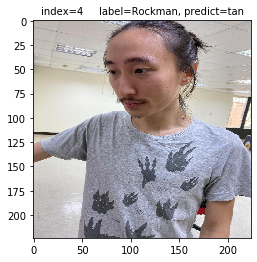

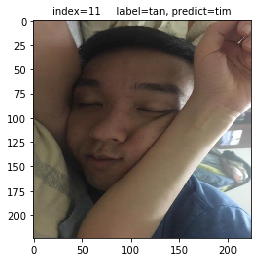

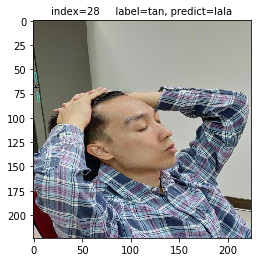

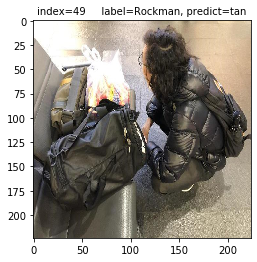

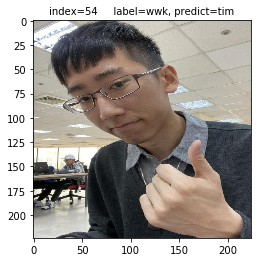

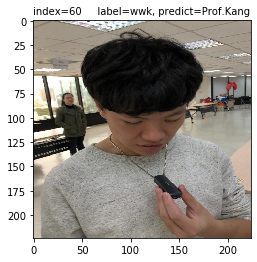

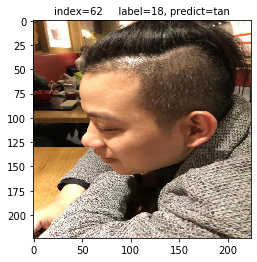

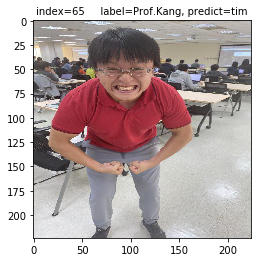

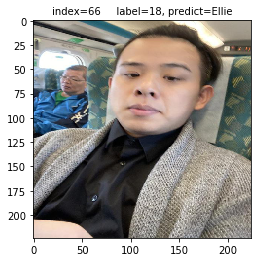

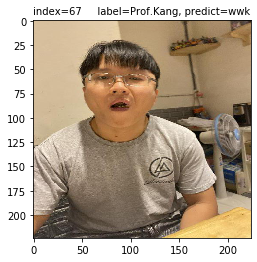

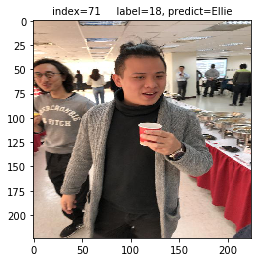

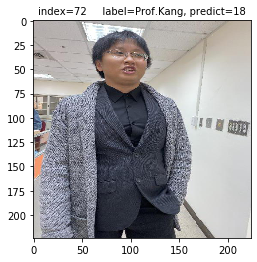

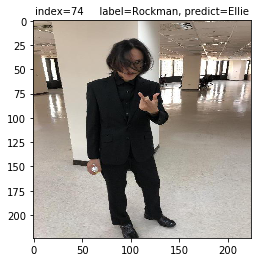

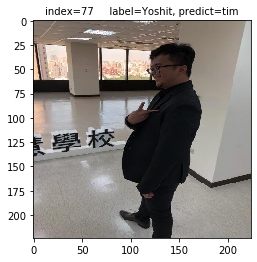

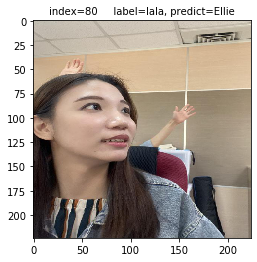

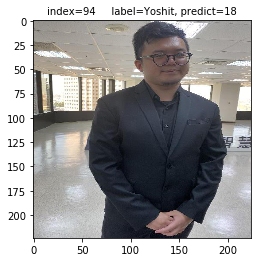

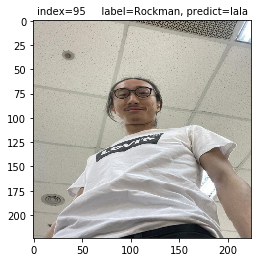

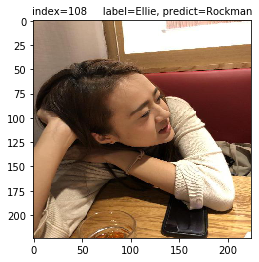

In [32]:
import matplotlib.pyplot as plt
fig = plt.gcf()

for i in range(len(wrongindex)) :
    plt.figure()
    plt.subplot(2,1+len(wrongindex)/2,1+i)
    
    fig.set_size_inches(3, 3)
    ax = plt.axes()
    plt.imshow(X_valid[wrongindex[i]])
   
    title ="index=" +str(wrongindex[i])
    ax.set_title(title,fontsize=10)       
    title+="     label=" +str(df_wrong['label_1'].iloc[i])
    ax.set_title(title,fontsize=10)
    title+=", predict=" +str(df_wrong['predict_1'].iloc[i])
    ax.set_title(title,fontsize=10) 


In [33]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,18,Ellie,Jerry,Prof.Kang,Rockman,Yoshit,lala,tan,tim,wwk
label,,,,,,,,,,
18,8,2,0,0,0,0,0,1,0,0
Ellie,0,13,0,0,1,0,0,0,0,0
Jerry,0,0,13,0,0,0,0,0,0,0
Prof.Kang,1,0,0,10,0,0,0,0,1,1
Rockman,0,1,0,0,9,0,1,2,0,0
Yoshit,1,0,0,0,0,8,0,0,1,0
lala,0,1,0,0,0,0,9,0,0,0
tan,0,0,0,0,0,0,1,19,1,0
tim,0,0,0,0,0,0,0,0,6,0


In [34]:
mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}

Text(91.68, 0.5, 'label')

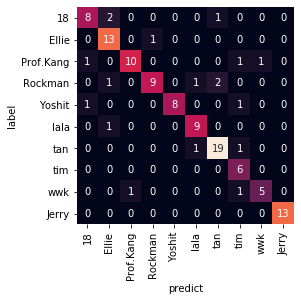

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_valid_1 , prediction_X_valid)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=mapping , yticklabels=mapping)
plt.xlabel('predict')
plt.ylabel('label')

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_1 , prediction_X_valid , target_names=mapping))

              precision    recall  f1-score   support

          18       0.80      0.73      0.76        11
       Ellie       0.76      0.93      0.84        14
   Prof.Kang       0.91      0.77      0.83        13
     Rockman       0.90      0.69      0.78        13
      Yoshit       1.00      0.80      0.89        10
        lala       0.82      0.90      0.86        10
         tan       0.86      0.90      0.88        21
         tim       0.60      1.00      0.75         6
         wwk       0.83      0.71      0.77         7
       Jerry       1.00      1.00      1.00        13

    accuracy                           0.85       118
   macro avg       0.85      0.84      0.84       118
weighted avg       0.86      0.85      0.85       118



# 預測 Test Data

In [37]:
img_paths = glob.glob('/home/jovyan/Midterm_DL/testset/*.jpg')
images = []
img_sizes = []
ids = []
for img_path in img_paths:
    ids.append(img_path.split("/")[-1].split(".")[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img[:,:]
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)

    images.append(img)

images_1 = np.array(images)


In [38]:
x_Test4D = images_1.reshape(images_1.shape[0],224,224,3).astype('float32') 

In [39]:
x_Test4D_normalize = x_Test4D/255

In [40]:
y_test_pred_prob = model.predict(x_Test4D_normalize)
prediction = y_test_pred_prob.argmax(axis=-1)

In [41]:
prediction[:10]

array([5, 5, 2, 7, 3, 8, 7, 3, 8, 9])

# Summit to Kaggle

In [42]:
submit = pd.read_csv("/home/jovyan/Midterm_DL/sample_submition.csv")

In [43]:
import pandas as pd
submit = pd.DataFrame({"id":ids, "class":prediction})

In [44]:
print(submit)

              id  class
0       IMG_5922      5
1       IMG_4066      5
2       IMG_1194      2
3    S__20275217      7
4       IMG_7365      3
..           ...    ...
127     IMG_0082      8
128     IMG_4833      4
129     IMG_0042      1
130     IMG_8804      3
131     IMG_7282      2

[132 rows x 2 columns]


In [45]:
submit.to_csv('VGG.csv', index = False)